In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Model Hyperparameters

In [2]:
batch_size=256
block_size=64
max_iter=10000
learning_rate=3e-4
eval_iters=100
n_embed=384
n_layer=12
n_head=8
dropout=0.2

# Loading Data

In [3]:
import os

path='/kaggle/input/training-data/D1.7GB/'

files = os.listdir('/kaggle/input/training-data/D1.7GB/')

text=''
for file in files:
    with open(path + file,'rb') as f:
        try:
            text += f.read().decode('utf-8')
        except:
            print(file)

999.txt


In [4]:
len(text)

1708249187

In [7]:
text[:1000]

'The Project Gutenberg Etext Song and Legend From the Middle Ages\r\nby William D. McClintock and Porter Lander McClintock\r\n\r\n\r\nCopyright laws are changing all over the world, be sure to check\r\nthe copyright laws for your country before posting these files!!\r\n\r\nPlease take a look at the important information in this header.\r\nWe encourage you to keep this file on your own disk, keeping an\r\nelectronic path open for the next readers.  Do not remove this.\r\n\r\n\r\n**Welcome To The World of Free Plain Vanilla Electronic Texts**\r\n\r\n**Etexts Readable By Both Humans and By Computers, Since 1971**\r\n\r\n*These Etexts Prepared By Hundreds of Volunteers and Donations*\r\n\r\nInformation on contacting Project Gutenberg to get Etexts, and\r\nfurther information is included below.  We need your donations.\r\n\r\n\r\nSong and Legend From the Middle Ages\r\n\r\nby William D. McClintock and Porter Lander McClintock\r\n\r\nSeptember, 1999  [Etext #1893]\r\n[Date last updated: June

#  Building Vocabulary

In [8]:
chars=sorted(list(set(text)))
vocab_size=len(chars)
print(''.join(chars))
print(vocab_size)

	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~¢£¨©ª®°±´¶»¼½ÂÃÉâæèéŸ—‘’“”€™﻿
145


# Building Tokenizer

In [9]:
dict1={ch:i for i,ch in enumerate(chars)}
dict2={i:ch for i,ch in enumerate(chars)}
encode= lambda s: [dict1[c] for c in s]  #encoder fun
decode= lambda l: ''.join(dict2[i] for i in l)  #decoder fun

print(encode("Hii there"))
print(decode(encode("Hii there")))

[61, 94, 94, 21, 105, 93, 90, 103, 90]
Hii there


# Encoded Input

In [10]:
# import torch
# data=torch.tensor(encode(text),dtype=torch.uint8)
# print(data.shape,data.dtype)
# print(data[:1000])

In [11]:
# import pickle
# with open('encoded_text.pkl', 'wb') as f:
#     pickle.dump(data, f)
# print('encoded text saved')

In [12]:
del text

# Train-test Split

In [13]:
import pickle
with open('/kaggle/input/model-utils/encoded_text.pkl', 'rb') as f:
    data = pickle.load(f)

In [14]:
n=int(0.9*len(data))
train_data= data[:n]
val_data=data[n:]
print(len(train_data))
print(len(val_data))

train_data=train_data.to(torch.long)
val_data=val_data.to(torch.long)

1537424268
170824919


In [15]:
del data

# Model Architecture

In [16]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y=x.to(device),y.to(device)
    return x, y

# A single attention head

In [17]:
class Head(nn.Module):
  def __init__(self,head_size):
    super().__init__()
    self.key=nn.Linear(n_embed,head_size,bias=False)
    self.query=nn.Linear(n_embed,head_size,bias=False)
    self.value=nn.Linear(n_embed,head_size,bias=False)
    self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    # input Of size (batch, time—step, channels )
    # output of size (batch, time—step, head size)
    B,T,C=x.shape
    k=self.key(x) # (B,T,C) @ (C,head_size)= (B,T,head_size)
    q=self.query(x) # (B,T,C) @ (C,head_size)= (B,T,head_size)
    wei=q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B,T,head_size) @ (B,head_size,T) = (B,T,T) as 4 batches(rows) and 8 characters in one row and every character is influenced by all the other charactrer (self-attention) ==> So, (B,T,T)
    wei=wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # (B,T,T)  # masking with -inf So, when applied softmax they will turn to 0
    wei=F.softmax(wei,dim=-1) # (B,T,T) Appling softmax on self attention dimension(last)
    wei=self.dropout(wei)
    # perform the wighted aggregation of the values
    v=self.value(x) # (B,T,head_size)
    out=wei @ v # (B,T,T) @ (B,T,head_size)= (B,T,head_size)
    return out

# Multihead Attention

In [18]:
class MultiHeadAttention(nn.Module):
  def __init__(self,num_heads,head_size):
    super().__init__()
    self.heads=nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # all the inner heads process in parallel unlike nn.Sequential where a sequence is followed
    self.proj=nn.Linear(head_size*num_heads,n_embed)
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    out=torch.cat([h(x) for h in self.heads],dim=-1) # (B, T, C) -> (B, T, [hl, hl, hl, hl, h2, h2, h2, h2, h3, h3, h3)
    # first we braek 384 into four parts, 96 features will be processed by 4 attention blocks  in parallel (96*4=384) and after the process of self attention done we conatenate the outputs of 4 heads making it a 384 dim again.
    # doing this we save our excessive computation cost and also get to attend to multiple meanings at the same time uisng multi-head attention
    out=self.dropout(self.proj(out))
    return out

In [19]:
class FeedForward(nn.Module):
  def __init__(self,n_embed):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(n_embed,4*n_embed),
        nn.ReLU(),
        nn.Linear(4*n_embed,n_embed),
        nn.Dropout(dropout)
    )
  def forward(self,x):
    return self.net(x)

In [20]:
class Block(nn.Module):
  #n_embed : Embedding dimension , n_head : the number of attention heads
  def __init__(self,n_embed,n_head):
    super().__init__()
    # (In spite of having one self attention attend to 384 features , we decrease the feature size to 96 and allow 8 different self-attention modules to attend to them.)
    # This increases the speed and also allows the gpt to understand multiple contexts from a single block (text).
    head_size=n_embed//n_head # 384/4 = 96
    self.sa=MultiHeadAttention(n_head,head_size)
    self.ffwd=FeedForward(n_embed)
    self.ln1=nn.LayerNorm(n_embed)
    self.ln2=nn.LayerNorm(n_embed)

  def forward(self,x):
    y=self.sa(x)
    x=self.ln1(x+y) # (works as a residual connection)
    y=self.ffwd(x)
    x=self.ln2(x+y) # (works as a residual connection)
    return x

In [21]:
class GPTLanguageModel(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.token_embedding_table=nn.Embedding(vocab_size,n_embed)
    self.position_embedding_table=nn.Embedding(block_size,n_embed)

    self.blocks=nn.Sequential(
        *[Block(n_embed,n_head) for _ in range(n_layer)]
        )

    self.ln_f=nn.LayerNorm(n_embed)
    self.lm_head=nn.Linear(n_embed,vocab_size)
    self.apply(self._init_weights)


  def _init_weights ( self, module): #initilaize weights with modrate  standard deviation to converge faster
    if isinstance(module,nn.Linear):
      torch.nn.init.normal_(module.weight,mean=0.0, std=0.02)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias)
    elif isinstance(module,nn.Embedding):
      torch.nn.init.normal_(module.weight,mean=0.0, std=0.02)

  def forward(self,index,targets=None):
    B, T = index.shape

    #returns A tensor of shape (B,T,C), where B is the batch size, T is the sequence length, and C is the embedding dimension.
    tok_emb=self.token_embedding_table(index) # (B,T,C)

    #returns A tensor of shape (T,C), where T is the sequence length and C is the embedding dimension.
    pos_emb=self.position_embedding_table(torch.arange(T,device=device)) # (T,C)

    x=tok_emb+pos_emb # will be added using broadcasting
    x=self.blocks(x) # (B,T,C)
    x=self.ln_f(x) # (B,T,C)
    logits=self.lm_head(x) # (B,T,vocab_size)

    if targets is None:
        loss = None
    else:
        B,T,C=logits.shape
        logits = logits.view(B*T, C) #reshape into 2D arrays (predicted value)
        targets = targets.view(B*T)  #reshape into 1D arrays (actual value)
        loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, index, max_new_tokens):
      # index is (B, T, C) array of indices in the current context
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        index_cond = index[:, -block_size:]
        # get the predictions
        logits, loss = self.forward(index_cond)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # append sampled index to the running sequence
        index = torch.cat((index, index_next), dim=1) # (B, T+1)
    return index



In [22]:
model = GPTLanguageModel(vocab_size)
model=model.to(device)

# Loss estimator function 

In [23]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# AdamW Optimizer

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_train=[]
loss_val=[]
epochs=[]

for iter in range(max_iter):
    if iter % eval_iters == 0:
        losses = estimate_loss() #evaluation (on validation data) will be done after every 100 iters
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")
        loss_train.append(losses['train'])
        loss_val.append(losses['val'])
        epochs.append(iter)

    # sample a batch of data
    xb, yb = get_batch('train')


    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

step: 0, train loss: 5.018, val loss: 5.034
step: 100, train loss: 2.150, val loss: 1.900
step: 200, train loss: 1.918, val loss: 1.729
step: 300, train loss: 1.785, val loss: 1.641
step: 400, train loss: 1.695, val loss: 1.586
step: 500, train loss: 1.639, val loss: 1.544
step: 600, train loss: 1.604, val loss: 1.515
step: 700, train loss: 1.567, val loss: 1.494
step: 800, train loss: 1.540, val loss: 1.478
step: 900, train loss: 1.523, val loss: 1.467
step: 1000, train loss: 1.505, val loss: 1.454
step: 1100, train loss: 1.490, val loss: 1.446
step: 1200, train loss: 1.473, val loss: 1.434
step: 1300, train loss: 1.465, val loss: 1.429
step: 1400, train loss: 1.455, val loss: 1.421
step: 1500, train loss: 1.444, val loss: 1.416
step: 1600, train loss: 1.439, val loss: 1.411
step: 1700, train loss: 1.433, val loss: 1.402
step: 1800, train loss: 1.428, val loss: 1.402
step: 1900, train loss: 1.419, val loss: 1.398
step: 2000, train loss: 1.410, val loss: 1.390
step: 2100, train loss: 1

# Exporting the model

In [25]:
import pickle
with open('tinyGPT.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

model saved


# Insights

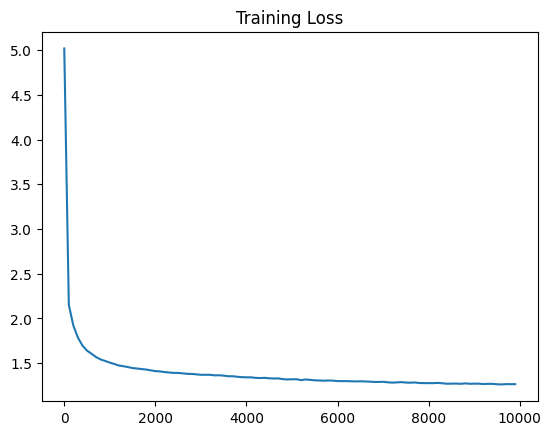

In [34]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.plot(epochs,loss_train)

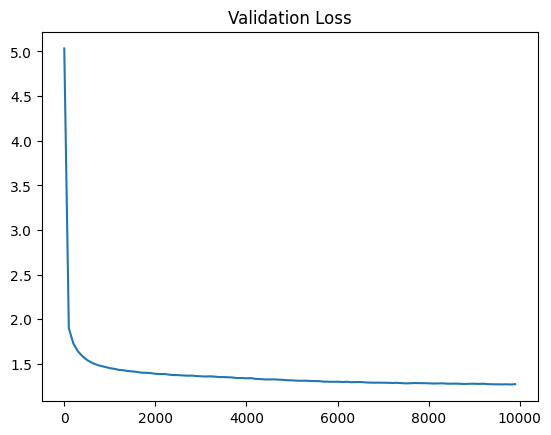

In [31]:
import matplotlib.pyplot as plt
plt.title('Validation Loss')

# Prompting the model

In [41]:
prompt = 'There was a'
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
# unsqueeze() adds a dimension at a specified index (3,) => (1,3)
generated_chars = decode(model.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
print(generated_chars)

There was a treach in the tall pack of the paschrops Amils. She wofore
lid their daughter, but fell irrupt and
